# Monte Carlo Convergence: Pseudo vs Quasi Random Numbers

<b> YouTube Tutorial </b> (Published: May 12, 2022): https://youtu.be/DbFJdjpTPok

## Generating Random Numbers for Monte Carlo

To simulate our risk-neutral price paths in derivative valuation through Monte Carlo simulation, we lean heavily on simulating Brownian motions through the generation of standard normal random variables.

Most programming languages and spreadsheets include a uniform pseudo-random number generator. This will generate a random integer between zero and a specified upper value, where each integers occur with equal probability. A standard uniform random generator, follows the mathematical definition, of real values in the range $\in (0,1)$, with all real values in that range equally likely.

A pseudo-random number generator is an algorithm for generating a sequence of numbers whose properties approximate the properties of sequences of random numbers. The generated sequence is not truly random, because it is completely determined by an initial value, called the seed (which may be seeded randomly - hence truly random). They are important for reproducibility and speed of generation.

With the standard uniform random number generator we can convert these to standard normal random numbers.

In [10]:
!pip install scipy --upgrade

In [11]:
import time
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

## Method 1: Approximation with 12 uniform samples
A common by approximate way to do this is to generate 12 standard normal random numbers, add them together and subtract 6 from the total. The distribution of this combination has a zero mean and variance of one.

In [12]:
np.random.seed = 1
N = 1e6

def add_12_uni(n):
    return np.sum([np.random.uniform(0,1,12) for i in range(int(n))], axis=1) - 6

start_time = time.time()
x_uni = add_12_uni(N)
time_uni = round(time.time() - start_time,3)
print("Computation Time: ", time_uni)

Computation Time:  2.939


Mean     : -0.002
Std      : 0.999
Skew     : -0.001
Kurtosis : -0.098
Min/Max  : -4.423/4.367


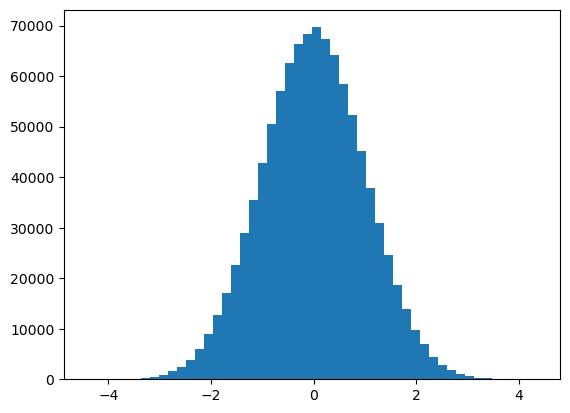

In [13]:
mean, std, skew, kurt = np.mean(x_uni), np.std(x_uni), stats.skew(x_uni), stats.kurtosis(x_uni)

print("Mean     :", round(mean,3))
print("Std      :", round(std,3))
print("Skew     :", round(skew,3))
print("Kurtosis :", round(kurt,3))
print("Min/Max  : {0}/{1}".format(round(min(x_uni),3), round(max(x_uni),3)))
plt.hist(x_uni, bins=50)
plt.show()

### This is a good approximation, However ...
- Maximum values are -6,6
- Also notice how Kurtosis is a little less than 3, which means that too many values close to the mean will be generated.

## Method 2: Box-Muller transformation

Simple Alternative, which is the exact transformation of pairs of standard uniform random numbers to pairs of standard normal random variables. Let $x_1$ and $x_2$ be standard uniformly distributed random pairs. Then standard normally distributed pairs $z_1$ and $z_2$ can be obtained:

$z_1 = \sqrt{-2ln(x_1)}cos(2\pi x_2)$

$z_2 = \sqrt{-2ln(x_1)}sin(2\pi x_2)$

In [14]:
N = 1e6

def box_muller(n):
    n = int(int(n)/2)
    x_uni = np.random.uniform(0,1,(2,n))
    z1 = np.sqrt(-2*np.log(x_uni[0]))*np.cos(2*np.pi*x_uni[1])
    z2 = np.sqrt(-2*np.log(x_uni[0]))*np.sin(2*np.pi*x_uni[1])
    return np.concatenate((z1,z2))

start_time = time.time()
x_box = box_muller(N)
time_box = round(time.time() - start_time,3)
print("Computation Time: ", time_box)

Computation Time:  0.036


Mean     : -0.0
Std      : 1.001
Skew     : 0.001
Kurtosis : -0.001
Min/Max  : -5.752/4.851


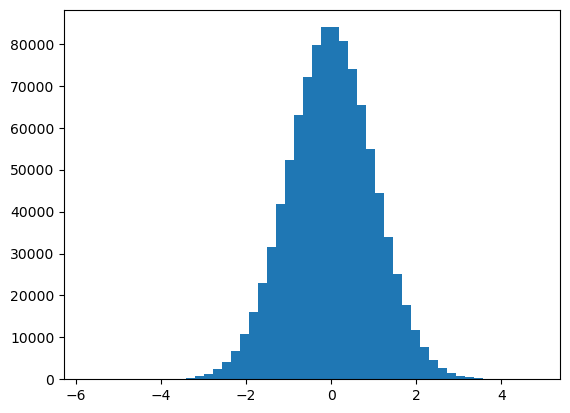

In [15]:
mean, std, skew, kurt = np.mean(x_box), np.std(x_box), stats.skew(x_box), stats.kurtosis(x_box)

print("Mean     :", round(mean,3))
print("Std      :", round(std,3))
print("Skew     :", round(skew,3))
print("Kurtosis :", round(kurt,3))
print("Min/Max  : {0}/{1}".format(round(min(x_box),3), round(max(x_box),3)))
plt.hist(x_box, bins=50)
plt.show()

## Method 3: Marsaglia Polar Rejection

Also requires pairs of uniformly distributed random numbers. To avoid using trigonometric functions of Box Muller transforms, let's consider polar coordinates. For this, we consider random variables, $x_1, x_2$ which are uniformly distributed on $[-1, 1]$ such that $x_1^2 + x_2^2 < 1$ It can be generated as follows.

while $w >= 1$ {
$x_1 =$ standard uniform random number

$x_2 =$ standard uniform random number

$w = x_1^2 + x_2^2$
}

then {

$ c = \sqrt{-2 \frac{ln(w)}{w}} $

$ z_1 = c*x_1$

$ z_2 = c*x_2$
}


    
    

In [16]:
N = 1e6

def polar_rejection(n):
    n = int(int(n)/2)
    x_uni = np.random.uniform(-1,1,(2,n))
    sum_squared = lambda x: x[0]**2+x[1]**2
    w = sum_squared(x_uni)
    cond = (sum_squared(x_uni)>=1)

    while np.any(cond):
        x_uni[:,cond] = np.random.uniform(-1,1,np.shape(x_uni[:,cond]))
        cond = (sum_squared(x_uni)>=1)

    w = sum_squared(x_uni)
    c = np.sqrt(-2*np.log(w)/w)
    return np.concatenate((c*x_uni[0],c*x_uni[1]))

start_time = time.time()
x_pol = polar_rejection(N)
time_pol = round(time.time() - start_time,3)
print("Computation Time: ", time_pol)

Computation Time:  0.05


Mean     : 0.001
Std      : 1.001
Skew     : 0.001
Kurtosis : 0.004
Min/Max  : -4.682/4.951


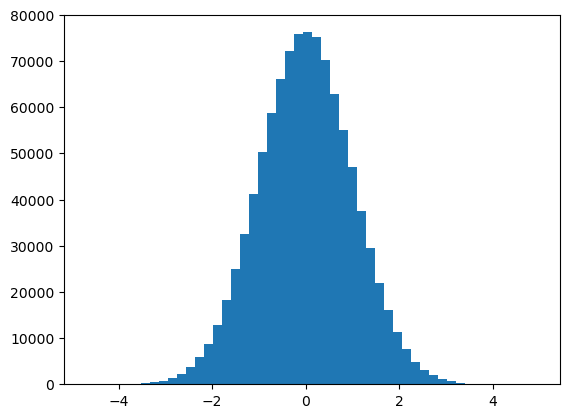

In [17]:
mean, std, skew, kurt = np.mean(x_pol), np.std(x_pol), stats.skew(x_pol), stats.kurtosis(x_pol)

print("Mean     :", round(mean,3))
print("Std      :", round(std,3))
print("Skew     :", round(skew,3))
print("Kurtosis :", round(kurt,3))
print("Min/Max  : {0}/{1}".format(round(min(x_pol),3), round(max(x_pol),3)))
plt.hist(x_pol, bins=50)
plt.show()

## Method 4: Inverse transform sampling

Let U be a random variable which is uniformly distributed on the interval $[0, 1]$. And let $F$ be a continuous CDF(cumulative distribution function) of a random variable, $X$ which we want to generate. Then, inverse CDF is defined by:

$F^{−1}(u)=inf\{x|F(x)\leq u,u \in [0,1]\}$

Using this inverse CDF, we can generate random variable X as following:

$X<−F^{−1}(u)$

The cumulative density function of the standard normal distribution is given by:

$\large f_X(x)=\frac{1}{\sqrt{2\pi}} e^{\frac{-x^2}{2}}$

This leads us into a problem. It can be shown that the integral $\int e^{-x^2} dx$ has no closed form using the standard elementary functions. That means that we have no way of finding a closed form of the normal CDF. Note there are closed form inverse CDF's for the Exponential, Pareto, Cauchy, Logistic, Rayleigh distributions.

Thankfully though, we have a workaround. Although we are unable to find a closed form for the inverse CDF, it is not too hard to approximate it using numerical analysis.

https://stats.stackexchange.com/questions/265925/what-is-inverse-cdf-normal-distribution-formula

In [18]:
N = 1e6

def inverse_norm(n):
    x_uni = np.random.uniform(0,1,int(n))
    return stats.norm.ppf(x_uni)

start_time = time.time()
x_inv = inverse_norm(N)
time_inv = round(time.time() - start_time,3)
print("Computation Time: ", time_inv)

Computation Time:  0.041


Mean     : -0.001
Std      : 1.001
Skew     : -0.004
Kurtosis : 0.011
Min/Max  : -4.876/4.991


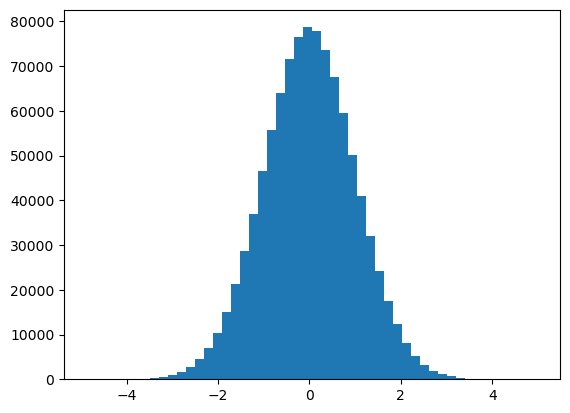

In [19]:
mean, std, skew, kurt = np.mean(x_inv), np.std(x_inv), stats.skew(x_inv), stats.kurtosis(x_inv)

print("Mean     :", round(mean,3))
print("Std      :", round(std,3))
print("Skew     :", round(skew,3))
print("Kurtosis :", round(kurt,3))
print("Min/Max  : {0}/{1}".format(round(min(x_inv),3), round(max(x_inv),3)))
plt.hist(x_inv, bins=50)
plt.show()

## ONLY Method in Python: Use Numpy!!!

Numpy uses Ziggurat algorithm. But use numpy directly as this is implemented in C, and executes way quicker than we could implement.
https://en.wikipedia.org/wiki/Ziggurat_algorithm
https://heliosphan.org/zigguratalgorithm/zigguratalgorithm.html

In [20]:
start_time = time.time()
x_norm = np.random.normal(0,1,int(N))
time_norm = round(time.time() - start_time,3)
print("Computation Time: ", time_norm)

Computation Time:  0.028


## Quasi-random numbers

Turns out, pseudo random numbers are a bad choice for Monte Carlo simulation. Let's consider pairs of independent uniformally distributed random numbers.

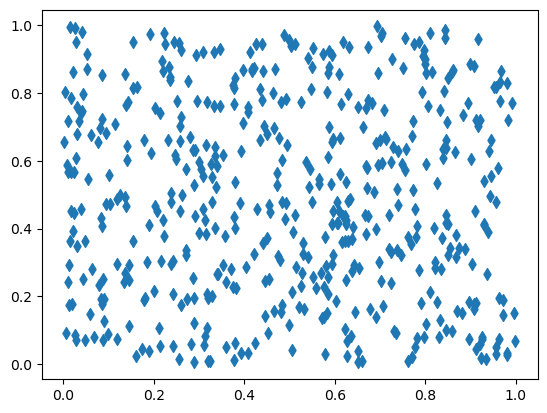

In [21]:
n = 500
x1 = np.random.uniform(0,1,int(n))
x2 = np.random.uniform(0,1,int(n))

plt.scatter(x1,x2, marker='d')
plt.show()

Since numbers are independent and uniformly distributed, every point on the graph is equally likely. However we observe clumps and empty spaces.

Eventually if we sampled enough points, the initial clumps and empty spaces would be swamped by the large number of points spread evenly.

Unfortunately, with Monte Carlo simulation, the aim is to often reduce the number of samples to decrease computation time (as has been the aim of Variance Reduction Techniques).
<b>Pseudo-random</b> numbers introduce bias through the clumpiness!

#### Quasi-random

In contrast, Quasi-random numbers or low-discrepency sequences are designed to appear random but not clumpy. Quasi-random samples are not independent from the previous one, it 'remembers' the previous samples and attempts to position itself away from other samples.

There are many methods to produce Quasi-random number generators, that provides several low discrepancy sequences:

- Faure sequence,
- Halton sequence,
- Reverse Halton sequence,
- Haselgrove sequence,
- Sobol sequence.

The behaviour is ideal for obtaining fast convergence in a Monte Carlo simulation. We show Halton and Sobol, because these are implemented in Scipy!

https://stackoverflow.com/questions/9412339/recommendations-for-low-discrepancy-e-g-sobol-quasi-random-sequences-in-pytho

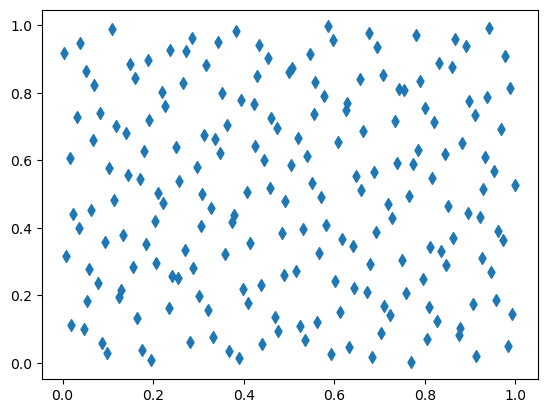

In [22]:
from scipy.stats import qmc

def halton(n, d=1):
    sampler = qmc.Halton(d, scramble=True)
    return sampler.random(n)

def halton_norm(n, d=1):
    sampler = qmc.Halton(d, scramble=True)
    x_halton = sampler.random(n)
    return stats.norm.ppf(x_halton)

x = halton(n=200, d=2).T
plt.scatter(x[0],x[1], marker='d')

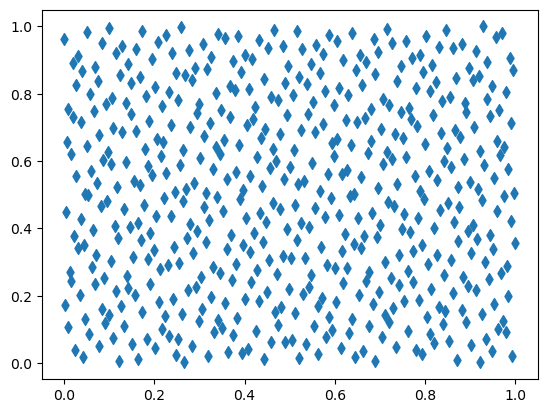

In [23]:
def sobol(m, d=1):
    sampler = qmc.Sobol(d, scramble=True)
    return sampler.random_base2(m)

def sobol_norm(m, d=1):
    sampler = qmc.Sobol(d, scramble=True)
    x_sobol = sampler.random_base2(m)
    return stats.norm.ppf(x_sobol)

x = sobol(m=9, d=2).T
plt.scatter(x[0],x[1], marker='d')

## Monte Carlo Convergence: Pseudo vs Quasi Random Numbers

Let's value a European option of which we have an exact solution for and use different methods of sampling to see the rate of convergence.
#### Pseudo-samping methods
- add 12 uniform variables
- Box-Muller
- Polar Rejection
- Inverse transform sampling (like Numpy)

#### Quasi-samping methods
- Halton
- Sobol

In [24]:
# Define variables
r = 0.01
S0 = 30
K = 32
T = 240/365
vol = 0.30

def blackScholes(r, S, K, T, sigma, type="c"):
    "Calculate BS price of call/put"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    try:
        if type == "c":
            price = S*stats.norm.cdf(d1, 0, 1) - K*np.exp(-r*T)*stats.norm.cdf(d2, 0, 1)
        elif type == "p":
            price = K*np.exp(-r*T)*stats.norm.cdf(-d2, 0, 1) - S*stats.norm.cdf(-d1, 0, 1)
        return price
    except:
        print("Please confirm option type, either 'c' for Call or 'p' for Put!")


bs = blackScholes(r, S0, K, T, vol, type="c")
print('Black Scholes Price', round(bs,3))

Black Scholes Price 2.18


In [25]:
results = {'Pseudo: add_12_uni': [],
           'Pseudo: box_muller': [],
           'Pseudo: polar_rejection:': [],
           'Pseudo: inv_transform': [],
           'Quasi : Halton': [],
           'Quasi : Sobol': [],}

funcs = {'Pseudo: add_12_uni': add_12_uni,
         'Pseudo: box_muller': box_muller,
         'Pseudo: polar_rejection:': polar_rejection,
         'Pseudo: inv_transform': inverse_norm,
         'Quasi : Halton': halton_norm,
         'Quasi : Sobol': sobol_norm}

numbers = np.linspace(0,4000,21)[1:]
# N = 10000

#precompute constants
dt = T
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)

# Monte Carlo Method
for M in numbers:
    M = int(M)
    for method in results:
        if method == 'Quasi : Sobol':
            continue
        else:
            Z = funcs[method](M)
        delta_St = nudt + volsdt*Z
        ST = S0*np.exp(delta_St)
        CT = np.maximum(0, ST - K)
        C0 = np.exp(-r*T)*np.sum(CT)/M

        results[method].append(C0 - bs)

sobol_rng = np.arange(7,13)
for M in sobol_rng:
    M = int(M)

    Z = funcs['Quasi : Sobol'](M)
    delta_St = nudt + volsdt*Z
    ST = S0*np.exp(delta_St)
    CT = np.maximum(0, ST - K)
    C0 = np.exp(-r*T)*np.sum(CT)/(2**M)

    results['Quasi : Sobol'].append(C0 - bs)


sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0)**2) / (M-1) )
SE = sigma/np.sqrt(M)

[]

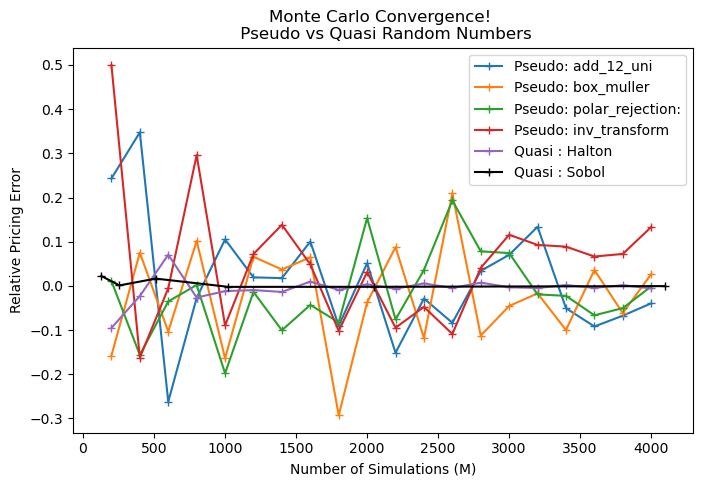

In [26]:
plt.figure(figsize=(8,5))
for method in results:
    if method == 'Quasi : Sobol':
        plt.plot(2**sobol_rng,results[method],label=method,color='k',marker='+')
    else:
        plt.plot(numbers,results[method],label=method,marker='+')
plt.legend()
plt.title('Monte Carlo Convergence! \n Pseudo vs Quasi Random Numbers')
plt.ylabel('Relative Pricing Error')
plt.xlabel('Number of Simulations (M)')
plt.plot()